# Optimizing and Training a CNN Model for Flower Image Classification

## Import the Necessary Libraries

In [84]:
# Importing the necessary libraries
import time
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Check for Available GPU

In [85]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Dataset Location

The dataset used for this classification task is the "Flower Classification 104 PNG" dataset from kaggle:

https://www.kaggle.com/datasets/alenic/flower-classification-512-png

This notebook should run on Kaggle and the dataset should already be loaded from the relavant option in the side menu. In order for the notrebook to run locally, the pathing for train_dir and val_dir should be adjusted accordingly.

Note: There is no data augmentation on this dataset and I chose not to apply either as the dataset is already too big and some experiments I made earlier with data augmentation increased the training times significantly.

In [86]:
# location of the training and validation data for the flower 512 dataset
train_dir = "/kaggle/input/flower-classification-512-png/images-png-512x512/train"
val_dir = "/kaggle/input/flower-classification-512-png/images-png-512x512/val"

## Resize Images | Set Batch Size | Create Train and Validation Datasets

The following code resizes the images to 180x180 and sets the batch size to 64.

In [87]:
image_size = (180, 180)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 12753 files belonging to 104 classes.
Found 3712 files belonging to 104 classes.


## Exploration of the Classes

In [88]:
class_names = train_ds.class_names

print('This dataset contains', len(class_names), 'flower classes.')

This dataset contains 104 flower classes.


## Sample Images

A sample of 9 images from the dataset.

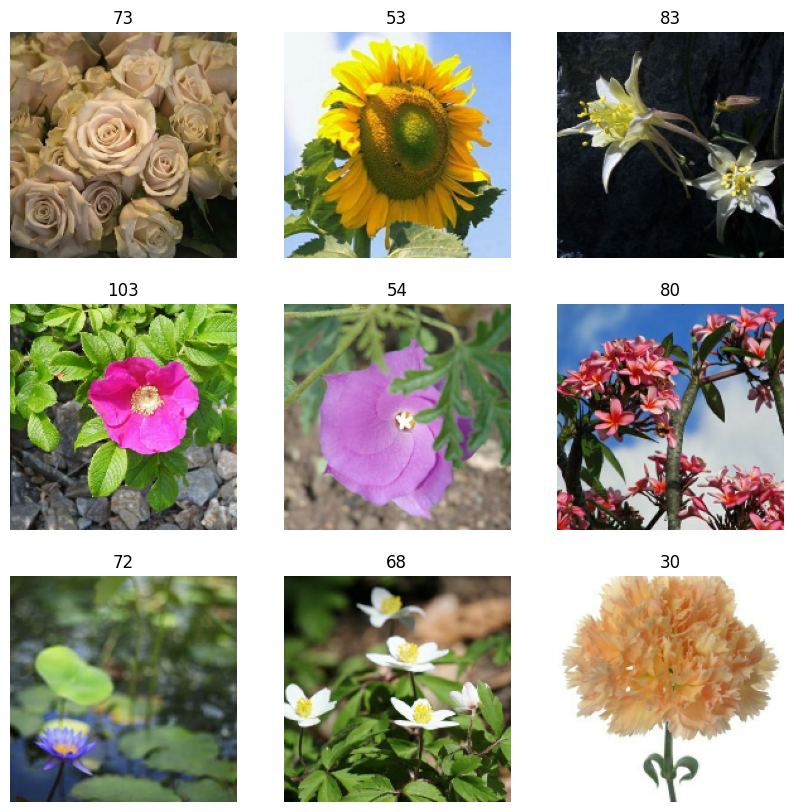

In [89]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = images[i].numpy().astype("uint8")
        label = labels[i].numpy()
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis("off")

## Helper Functions

Before we start training the models we are going to need some functions to facilitate this process. The first of them diplays some general stats about the model, like the layer structure and the amount of trainable and non-trainable (frozen) parameters.

In [90]:
# A function that displays the model layers and the parameters of each layer as well as the frozen (non-trainable) parameters
def display_model_stats(model):
    print(model.summary())

The next function will be used to display the fluctuations of the training and validation accuracy and loss throughtout the training of the model. After the training of each model the function will output these stats in graph form.

In [91]:
# A function to plot the training and validation accuracy and loss
def plot_model_accuracy_and_loss(metrics):
    acc = metrics.history["accuracy"]
    val_acc = metrics.history["val_accuracy"]
    loss = metrics.history["loss"]
    val_loss = metrics.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training and validation accuracy
    ax1.plot(epochs, acc, "r", label="Training accuracy")
    ax1.plot(epochs, val_acc, "g", label="Validation accuracy")
    ax1.set_title("Training and Validation accuracy")
    ax1.legend()

    # Plot training and validation loss
    ax2.plot(epochs, loss, "r", label="Training loss")
    ax2.plot(epochs, val_loss, "g", label="Validation loss")
    ax2.set_title("Training and Validation loss")
    ax2.legend()

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Display the figure
    plt.show()

This array will store the statistics of all models trained in order to extract meaningful information after all models have finished training.

In [92]:
# An array that will store all training data for the models like time and epochs to extract general statistics later
global_model_stats = []

The function train_model compiles the model given as an input and then decides which callback function will be used based on the rest of the inputs during the training of the model. The time needed to train the model is also calculated, as well as the average time needed per epochs which will be particularly useful as some models were trained in a different number of epochs than others.

In [93]:
# A function to compile and fit the model that also returns metrics
def train_model(model, train_dataset, validation_dataset, epochs, early_stopping = False, save_model = False):
    # Compile the Model
    model.compile(loss="sparse_categorical_crossentropy",
             metrics=["accuracy"],
             optimizer="adam")
    
    # Start the timer
    start_time = time.time()
    
    # Check if the model is not improving validation loss and stop early
    # In this case it will always be False to help with visualizations
    if early_stopping == True:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[es_callback])
    # Option to save the model
    elif save_model == True:
        checkpoint_filepath = '/kaggle/working/'+ model.name +'.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, callbacks=[model_checkpoint_callback])
    else:
        metrics = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)
        
    # Calculate the model metrics
    end_time = time.time()
    training_time = int(end_time - start_time)
    training_time_per_epoch = round(training_time/epochs, 2)
    highest_train_accuracy = max(metrics.history['accuracy'])
    highest_val_accuracy = max(metrics.history['val_accuracy'])

    # Saving the model's metrics to the array
    global_model_stats.append([model.name, training_time, epochs, training_time_per_epoch, highest_train_accuracy, highest_val_accuracy])
    
    print('-----------------------------------------------------------------------------------')
    print(f'The training of the {model.name} required a total of {training_time} seconds for {epochs} epochs.')
    
    return metrics

##  A Basic CNN Model with 4 Convolutional Layers

The first model tested is a pretty basic CNN architecture with 4 convolutional layers with progressively increasing number of filters. Every convolutional layer is followed by a MaxPooling2D layer and before the final classification (Dense) layer there is a Flatten layer.

In [94]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Flatten()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_1 = keras.Model(inputs, outputs, name = 'Basic_CNN_Model')

Using the function we defined earlier we can see the model architecture, as well as the parameters to be trained in each layer.

In [95]:
# Visualization of the model layers
display_model_stats(model_1)

Model: "Basic_CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                              

In [96]:
# Training of the model
model_1_metrics = train_model(model_1, train_ds, val_ds, 15)

Epoch 1/15
200/200 [==============================] - 149s 714ms/step - loss: 3.5156 - accuracy: 0.1592 - val_loss: 3.0056 - val_accuracy: 0.2306
Epoch 2/15
200/200 [==============================] - 136s 661ms/step - loss: 2.7496 - accuracy: 0.2831 - val_loss: 2.6239 - val_accuracy: 0.3206
Epoch 3/15
200/200 [==============================] - 138s 670ms/step - loss: 2.1506 - accuracy: 0.4201 - val_loss: 2.4996 - val_accuracy: 0.3642
Epoch 4/15
200/200 [==============================] - 138s 672ms/step - loss: 1.5211 - accuracy: 0.5691 - val_loss: 2.7261 - val_accuracy: 0.3801
Epoch 5/15
200/200 [==============================] - 137s 665ms/step - loss: 0.9204 - accuracy: 0.7270 - val_loss: 3.1768 - val_accuracy: 0.3772
Epoch 6/15
200/200 [==============================] - 148s 719ms/step - loss: 0.5346 - accuracy: 0.8341 - val_loss: 3.7648 - val_accuracy: 0.3947
Epoch 7/15
200/200 [==============================] - 138s 670ms/step - loss: 0.3023 - accuracy: 0.9052 - val_loss: 4.5359 -

After training the model for 15 epochs we can see that it has clearly overfit the training data as the validation accuracy reaches a plateau after 4 epochs while the training accuracy continues to increase and gets really close to perfect. The validation loss also increases, another indicator that the model doesn't generalize well.

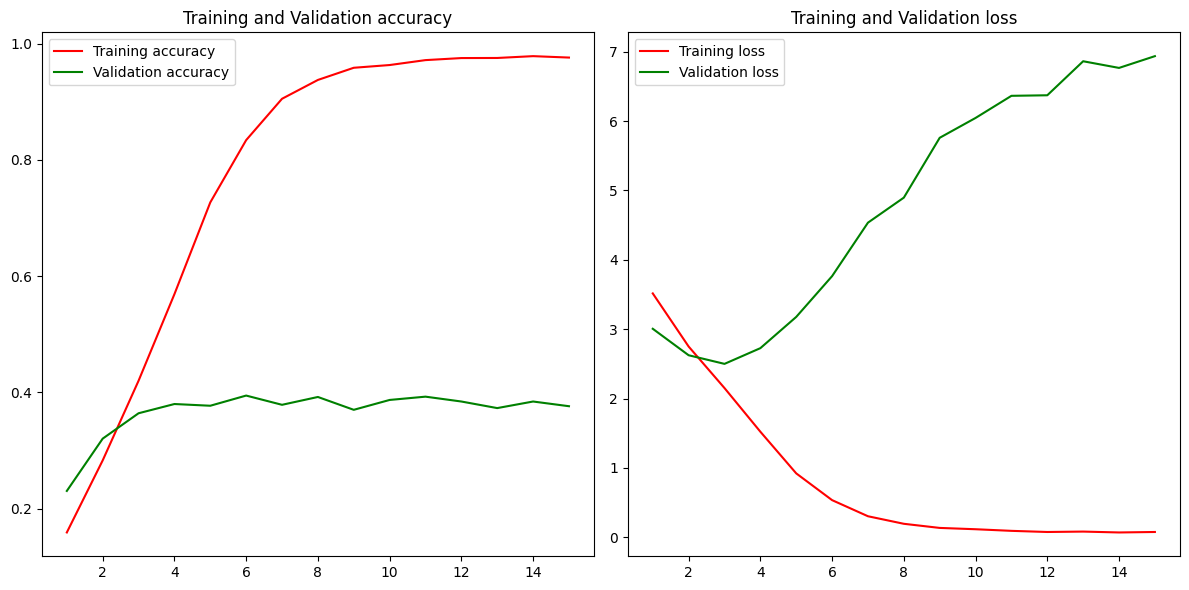

In [97]:
# Display stats
plot_model_accuracy_and_loss(model_1_metrics)

## Dropout Layers to Reduce Overfitting

The first approach to reduce overfitting is to add a Dropout layer after each colvolutional layer.

Dropout layers serve two primary purposes: 
* First, by dropping out neurons, the model becomes less reliant on any single neuron or set of neurons with perceived greater value. This encourages the model to learn more robust and generalizable representations of the data. 
* Second, dropout acts as a form of regularization by introducing noise and reducing co-adaptation between neurons, thereby preventing overfitting and improving the model's ability to generalize to unseen data.

In [98]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Flatten()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_2 = keras.Model(inputs, outputs, name = 'Model_with_Dropout_Layers')

In [99]:
# Visualization of the model layers
display_model_stats(model_2)

Model: "Model_with_Dropout_Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 64)        18496     
                                         

In [100]:
# Training of the model
model_2_metrics = train_model(model_2, train_ds, val_ds, 15)

Epoch 1/15


2023-10-17 08:52:10.421344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_with_Dropout_Layers/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 142s 681ms/step - loss: 3.5054 - accuracy: 0.1633 - val_loss: 3.7289 - val_accuracy: 0.2018
Epoch 2/15
200/200 [==============================] - 141s 683ms/step - loss: 2.7472 - accuracy: 0.2879 - val_loss: 3.3661 - val_accuracy: 0.3058
Epoch 3/15
200/200 [==============================] - 140s 681ms/step - loss: 2.1642 - accuracy: 0.4199 - val_loss: 2.9966 - val_accuracy: 0.3817
Epoch 4/15
200/200 [==============================] - 153s 743ms/step - loss: 1.5727 - accuracy: 0.5562 - val_loss: 2.6317 - val_accuracy: 0.4057
Epoch 5/15
200/200 [==============================] - 141s 683ms/step - loss: 1.0491 - accuracy: 0.6907 - val_loss: 2.4872 - val_accuracy: 0.3936
Epoch 6/15
200/200 [==============================] - 141s 685ms/step - loss: 0.7107 - accuracy: 0.7824 - val_loss: 2.3845 - val_accuracy: 0.4098
Epoch 7/15
200/200 [==============================] - 140s 679ms/step - loss: 0.5003 - accuracy: 0.8475 - val_loss: 2.3486 - val_accura

The addition of dropout layers managed to reduce the validation loss significantly, though it didn't offer much in terms of accuracy.

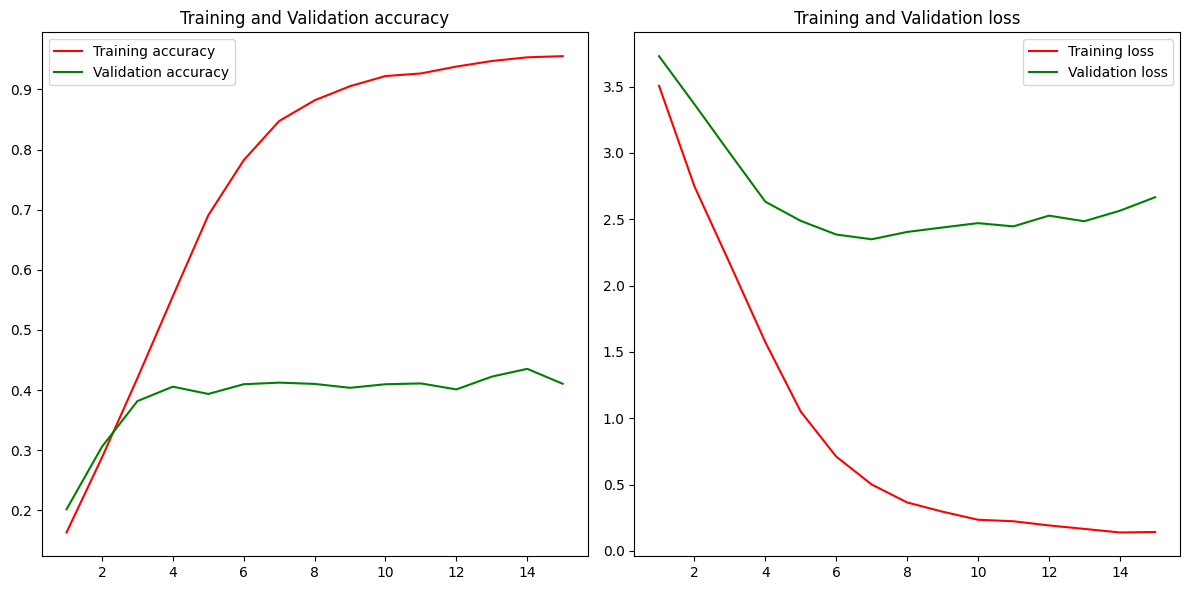

In [101]:
# Display stats
plot_model_accuracy_and_loss(model_2_metrics)

## Replacing the Flatten Layer with a GlobalMaxPooling2D Layer

The next step is to replace the Flatten layer before the final Dense layer with a Global Max Pooling 2D layer. Compared to the Flatten layer, which converts the 2D feature maps into a 1D vector, GlobalMaxPooling2D reduces the dimensionality of the feature maps while still preserving the most important spatial information. A major advantage of the GlobalMaxPooling2D layer compared to the Flatten layer is that the former considers the entire feature map, enabling the network to capture global context information. This global perspective is particularly useful for tasks that require a holistic understanding of the input, such as the current classification problem. The addition of the GlobalMaxPooling2D layer will also decrease the number of parameters significantly.

In [102]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.GlobalMaxPooling2D()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_3 = keras.Model(inputs, outputs, name='Model_with_GlobalMaxPooling2D_Layer')

In [103]:
# Visualization of the model layers
display_model_stats(model_3)

Model: "Model_with_GlobalMaxPooling2D_Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 87, 87, 64)        18496     
                               

In [104]:
# Training of the model
model_3_metrics = train_model(model_3, train_ds, val_ds, 15)

Epoch 1/15


2023-10-17 09:29:20.941633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_with_GlobalMaxPooling2D_Layer/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 143s 686ms/step - loss: 3.7517 - accuracy: 0.1235 - val_loss: 4.2932 - val_accuracy: 0.1791
Epoch 2/15
200/200 [==============================] - 139s 673ms/step - loss: 2.9886 - accuracy: 0.2540 - val_loss: 3.8689 - val_accuracy: 0.3006
Epoch 3/15
200/200 [==============================] - 139s 675ms/step - loss: 2.6070 - accuracy: 0.3332 - val_loss: 3.5518 - val_accuracy: 0.3621
Epoch 4/15
200/200 [==============================] - 140s 676ms/step - loss: 2.3276 - accuracy: 0.3975 - val_loss: 3.3545 - val_accuracy: 0.3960
Epoch 5/15
200/200 [==============================] - 139s 678ms/step - loss: 2.0958 - accuracy: 0.4520 - val_loss: 3.2423 - val_accuracy: 0.4291
Epoch 6/15
200/200 [==============================] - 142s 691ms/step - loss: 1.9064 - accuracy: 0.4950 - val_loss: 3.1940 - val_accuracy: 0.4714
Epoch 7/15
200/200 [==============================] - 140s 680ms/step - loss: 1.7501 - accuracy: 0.5372 - val_loss: 3.0233 - val_accura

The addition of the GlobalMaxPooling2D layer drastically improved the validation accuracy, while at the same time reducing the training accuracy, which show that our model no loger overfits the data. As a matter of fact it seems like the validation accuracy would continue to improve if the model was trained for more epochs.

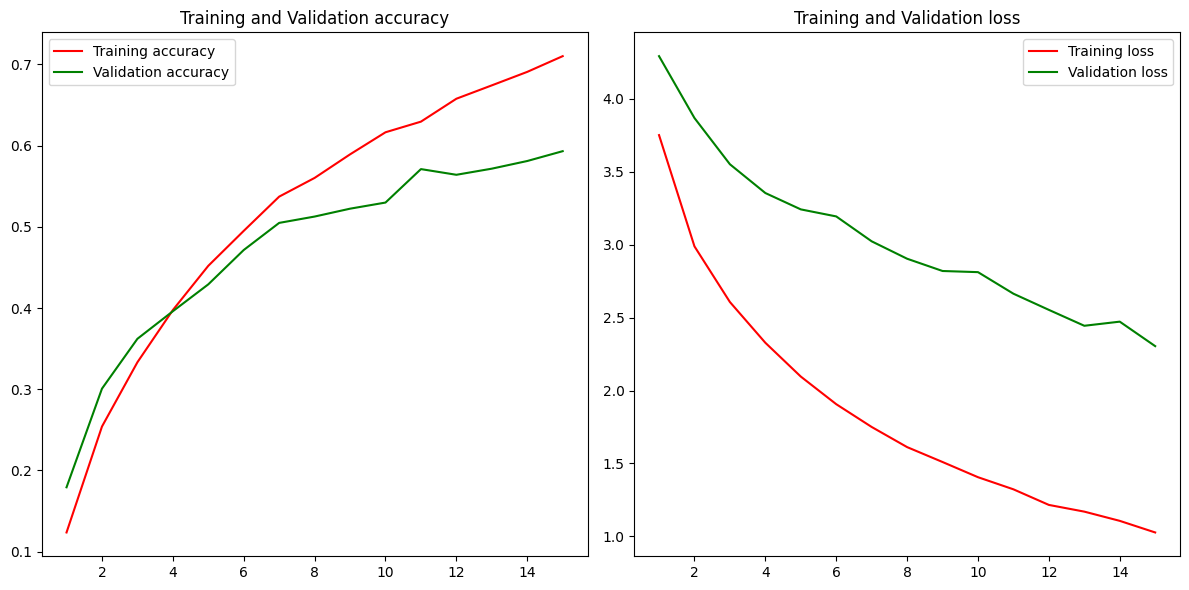

In [105]:
# Display stats
plot_model_accuracy_and_loss(model_3_metrics)

## Adding L1/L2 Regularization

In the final model, L1/L2 regularization is inserted in the first 2 convolutional layers. Through the penalties applied to the loss function this approach manages to keep the overall weights lower. Specifically, L1 regularization promotes sparsity and feature selection, while L2 regularization encourages overall weight reduction.
So, the L1/L2 regularization is expected to further reduce overfitting and improve the model's ability to generalize.

In [106]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(128, (3, 3), activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, (3, 3), activation="relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.GlobalMaxPooling2D()(x)

outputs = layers.Dense(525, activation="softmax")(x)

model_4 = keras.Model(inputs, outputs, name = 'Model_with_L1L2_Regularization')

In [107]:
# Visualization of the model layers
display_model_stats(model_4)

Model: "Model_with_L1L2_Regularization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 dropout_8 (Dropout)         (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 87, 87, 64)        18496     
                                    

In [108]:
# Training of the model
model_4_metrics = train_model(model_4, train_ds, val_ds, 50, save_model = True)

Epoch 1/50


2023-10-17 10:07:32.675331: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_with_L1L2_Regularization/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 143s 682ms/step - loss: 3.7083 - accuracy: 0.1355 - val_loss: 4.1251 - val_accuracy: 0.2284
Epoch 2/50
200/200 [==============================] - 138s 673ms/step - loss: 2.9721 - accuracy: 0.2481 - val_loss: 3.8825 - val_accuracy: 0.3028
Epoch 3/50
200/200 [==============================] - 139s 677ms/step - loss: 2.5928 - accuracy: 0.3315 - val_loss: 3.6373 - val_accuracy: 0.3551
Epoch 4/50
200/200 [==============================] - 138s 672ms/step - loss: 2.2682 - accuracy: 0.4122 - val_loss: 3.3406 - val_accuracy: 0.4259
Epoch 5/50
200/200 [==============================] - 138s 669ms/step - loss: 2.0091 - accuracy: 0.4703 - val_loss: 3.1507 - val_accuracy: 0.4628
Epoch 6/50
200/200 [==============================] - 139s 674ms/step - loss: 1.8113 - accuracy: 0.5178 - val_loss: 3.0344 - val_accuracy: 0.4841
Epoch 7/50
200/200 [==============================] - 140s 680ms/step - loss: 1.6656 - accuracy: 0.5545 - val_loss: 2.7848 - val_accura

After training this model for 50 epochs we can see that the validation accuracy was marginally improved (from 59% to 63%) compared to the previous best model. Given the large number of classes this improvement might seem small but it is actually significant.

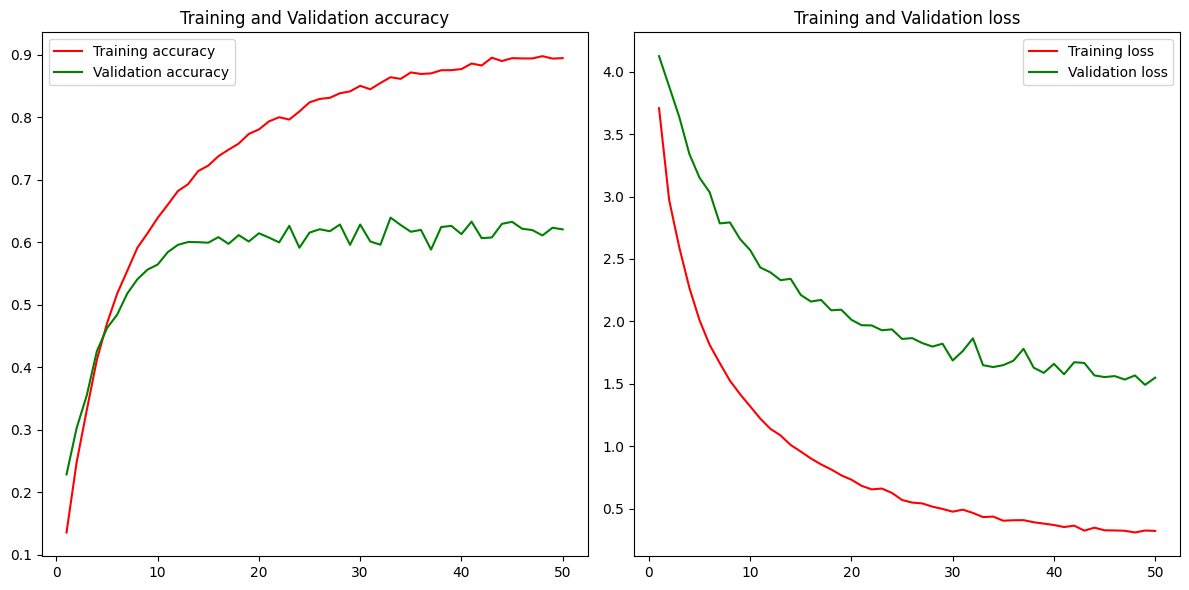

In [109]:
# Display stats
plot_model_accuracy_and_loss(model_4_metrics)

## Adding Residual Connections

The final step is to add residual connections to the model. After the two first convolutional layers, this network contains 6 more blocks of convolutional layers with residual connections. Every block contains two convolutional layers followed by a BatchNormalization layer and a Dropout layer. We are also removing the dropout from the first two convolutional layers in this model and instead adding it only to the 6 blocks. The 6 blocks of residual connections are followed by a GlobalMaxPooling2D layer, a Dropout layer and the final classification layer.

In [110]:
# A function to create the residual blocks
def residual_block(x, filters, stride=1, dropout_rate=0.2):
    identity = x

    # First convolutional layer
    x = layers.Conv2D(filters, (3,3), strides=stride, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Residual connection
    if stride > 1:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', )(identity)
    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)

    return x

In [111]:
input_shape = (180, 180, 3)
num_classes = 525

# Create the Model with Residual Connections
inputs = tf.keras.Input(shape=input_shape)

# Initial convolutional layers
x = layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(inputs)
x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=keras.regularizers.L1L2())(x)
x = layers.MaxPooling2D(2, 2)(x)

# Residual blocks
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, stride=2)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, stride=2)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, stride=2)

# Final layers
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_with_residual = tf.keras.Model(inputs, outputs, name = 'Model_with_Residual_Connections')

In [112]:
# Visualization of the model layers
display_model_stats(model_with_residual)

Model: "Model_with_Residual_Connections"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 178, 178, 32  896         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_34 (MaxPooling2D  (None, 89, 89, 32)  0           ['conv2d_36[0][0]']              
 )                                                                  

In [113]:
# Training of the model
model_with_residual_stats = train_model(model_with_residual, train_ds, val_ds, 50, save_model=True)

Epoch 1/50


2023-10-17 12:08:22.848034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inModel_with_Residual_Connections/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 158s 705ms/step - loss: 4.5969 - accuracy: 0.1061 - val_loss: 3.5480 - val_accuracy: 0.1587
Epoch 2/50
200/200 [==============================] - 146s 707ms/step - loss: 3.3517 - accuracy: 0.1809 - val_loss: 3.0393 - val_accuracy: 0.2427
Epoch 3/50
200/200 [==============================] - 146s 709ms/step - loss: 3.0587 - accuracy: 0.2271 - val_loss: 2.9653 - val_accuracy: 0.2532
Epoch 4/50
200/200 [==============================] - 149s 722ms/step - loss: 2.8697 - accuracy: 0.2603 - val_loss: 2.7022 - val_accuracy: 0.3036
Epoch 5/50
200/200 [==============================] - 145s 702ms/step - loss: 2.6804 - accuracy: 0.3065 - val_loss: 2.5033 - val_accuracy: 0.3421
Epoch 6/50
200/200 [==============================] - 146s 708ms/step - loss: 2.5086 - accuracy: 0.3359 - val_loss: 2.4737 - val_accuracy: 0.3545
Epoch 7/50
200/200 [==============================] - 147s 709ms/step - loss: 2.3490 - accuracy: 0.3727 - val_loss: 2.3384 - val_accura

As we can see the addition of residual blocks did in fact decreased the accuracy of the model back 4% and it also increased the training time as the model parameters also increased by a lot. Perhaps should more epochs were to follow, we could see the expected results of validation accuracy rising even more than before.

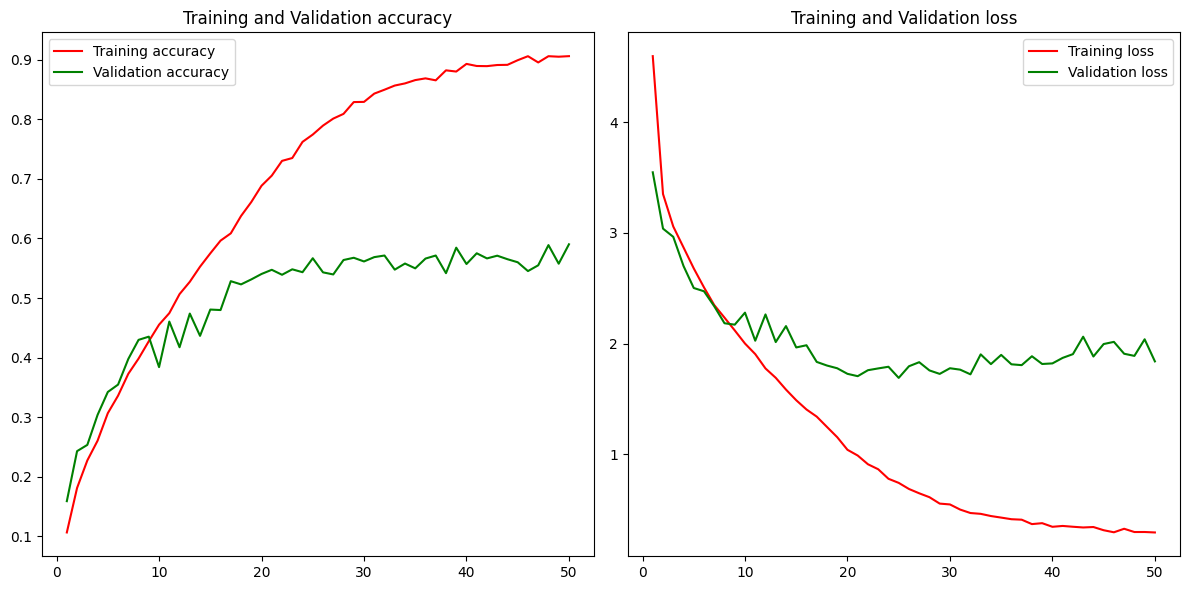

In [114]:
# Display stats
plot_model_accuracy_and_loss(model_with_residual_stats)

## Final Statistics and Obesrvations

The following table shows that the earlier models with flatten layer and without dropout tend to overfit alot and learn the training data too well. Both the addition of Dropout layers and the replacement of the Flatten layer with a GlobalMaxPooling 2D layer was enough to stop the model from overfitting and improve the validation accuracy. The L1/L2 regularization also improved the accuracy while keeping the training times relatively low. Finally, the addition of residual blocks was met with a decrease in accuracy and it also increased the training time as we are now training more parameters.

In [115]:
print(tabulate(global_model_stats, headers=['Model Name', 'Training Time', 'Number of Epochs', 'Training Time per Epoch', 'Training Accuracy', 'Validation Accuracy'], tablefmt="fancy_grid"))

╒═════════════════════════════════════╤═════════════════╤════════════════════╤═══════════════════════════╤═════════════════════╤═══════════════════════╕
│ Model Name                          │   Training Time │   Number of Epochs │   Training Time per Epoch │   Training Accuracy │   Validation Accuracy │
╞═════════════════════════════════════╪═════════════════╪════════════════════╪═══════════════════════════╪═════════════════════╪═══════════════════════╡
│ Basic_CNN_Model                     │            2116 │                 15 │                    141.07 │            0.978515 │              0.394666 │
├─────────────────────────────────────┼─────────────────┼────────────────────┼───────────────────────────┼─────────────────────┼───────────────────────┤
│ Model_with_Dropout_Layers           │            2229 │                 15 │                    148.6  │            0.955383 │              0.435345 │
├─────────────────────────────────────┼─────────────────┼────────────────────┼────